# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Mohamed_Rostom"
ln1 = "GHARBI"


filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_gharbi_mohamed_rostom.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<div class="alert alert-info">
    <h2> Table of content </h2>

[1. Introduction](#Intro)<br>
[2. Proximal operators](#ProxOp)<br>
[3. Gradients](#grad)<br>
[4. Solvers](#solv)<br>
[5. Exercice](#exer)<br>


</div>

<a id='Intro'></a>
## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

<div class="alert alert-info">
    <h3> <center> All markdowns in blue frame, are my comments for the differents lab questions. </center> </h3>
</div>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

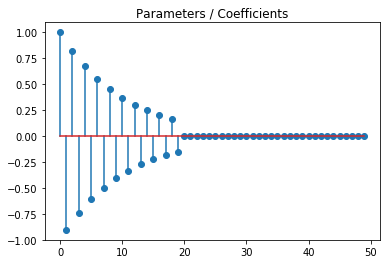

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

<a id='ProxOp'></a>
## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * np.maximum(0, np.abs(x)-s) 
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x, ord=1) 

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x/float(1+s) 
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return (s/2.) * np.linalg.norm(x, ord=2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

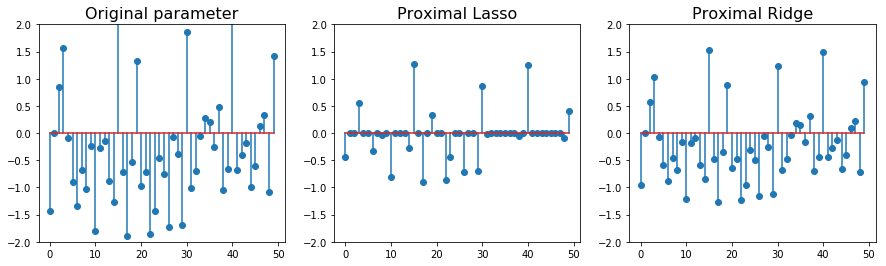

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>

*  We can see that the Proximal Lasso induces sparsity on the coefficients.Indeed, it tends to penalize weights with an absolute value higher than s.

*   On the other hand, the Proximal Ridge attempts to make weights as small as possible by shrinking them using the factor  1/1+s  (which is equal to  1/1.5≃0.67).

</ul>
</div>

<a id='grad'></a>
## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features. <br>

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>

**LINEAR REGRESSION :**

We know that we have : 

$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$

So simply :

$$\triangledown f = \frac{1}{n}A^T.(A x-b)$$


**LOGISTIC REGRESSION :**

For this type of regression we have : 

$$f( x) = \frac{1}{n}\sum_{i=1}^n{log\left(1+ e^{-b_i\left(a_i^Tx\right)}\right)}$$

With $A$  by $ A= \begin{pmatrix}
                    a_1^T & \\ 
                    \vdots & \\
                    a_n^T & \\
\end{pmatrix}$

$$\triangledown f = \frac{1}{n}\sum_{i=1}^n{ \frac{ -b_ia_ie^{-b_ia_i^Tx}}{1+e^{-b_ia_i^Tx}}}$$

then we simply multiply it by : **$$e^{b_ia_i^Tx}$$** and we get eventually: 

$$\triangledown f =  -\frac{1}{n}\sum_{i=1}^n{\frac{ b_i a_i}{1+e^{b_ia_i^Tx}} }$$

</ul>
</div>


In [8]:
def loss_linreg(x):
    """Least-squares loss"""
    return ((1/(2*A.shape[0]))*np.linalg.norm(A.dot(x)-b,ord=2)**2)

def grad_linreg(x):
    """Leas-squares gradient"""
    return((1/A.shape[0])*A.T.dot(A.dot(x)-b))

def loss_logreg(x):
    """Logistic loss"""
    return (1./ A_log.shape[0])*np.sum(np.log(1+np.exp(-b_log*(A_log.dot(x)))))

def grad_logreg(x):
    """Logistic gradient"""
    return - A_log.T.dot(b_log*(1./(1.+np.exp(b_log * A_log.dot(x))))) / A_log.shape[0]

Now, we're going to check if the functions that I coded are working well or not. I will use, the function check_grand from scipy.optimize. 

#### Check our functions for the linear regression :

In [9]:
#Import :
from scipy import optimize

#Check that these functions are correct by numerically checking the gradient
A, b = simu_linreg(coefs)

f = lambda x : loss_linreg(x)
f_grad = lambda x : grad_linreg(x)

err = optimize.check_grad(f, f_grad, x)
print('Error :%s'%err)
rel_err = err / np.linalg.norm(f_grad(x))
print('relative error : %s'%rel_err)

Error :6.9377560767530515e-06
relative error : 5.492966326108809e-07


<div class="alert alert-info">
We can see that both the error and the relative error confirm that the gradient function I coded seems to work well. 
    
</div>

#### Logistic regression : 

In [10]:
#Check that these functions are correct by numerically checking the gradient
A_log, b_log = simu_logreg(coefs)

h = lambda x : loss_logreg(x)
h_grad = lambda x : grad_logreg(x)

err = optimize.check_grad(h, h_grad, x)
print('Error :%s'%err)
rel_err = err / np.linalg.norm(h_grad(x))
print('relative error : %s'%rel_err)

Error :2.5913566082137876e-07
relative error : 4.371757314824881e-07


<div class="alert alert-info">
Same here, the error and the relative error we found seem to show that the functions I coded works well. 
    </div>

<a id='solv'></a>
## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

<div class="alert alert-info">

$L$ is the Lipschitz constant of $f$. 

For linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n}  \quad 
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} \quad .
$$
For full-gradient methods, the theoretical step-size is $1 / L$ .

</div>

In [11]:
#----------------------------------------------------
# COMMENT : For linear regression, L = Sigma_max(A)/n
def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    return max(s)**2 / A.shape[0]

#----------------------------------------------------

In [12]:
#----------------------------------------------------
# COMMENT : For Logistic regression, L = Sigma_max(A)²/4*n
def lip_logreg(A_log):
    """Lipschitz constant for logistic loss"""    
    u, s, vh = np.linalg.svd(A_log, full_matrices=False)
    return max(s)**2 / (4 * A_log.shape[0])

#----------------------------------------------------

In [13]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO #### ----------------------------------------------------------
        x = prox_g(x - (1. / step) * grad_f(x), float(s) / step)
        #------------------------------------------------------------------------
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        
        errors.append(err)
        objectives.append(obj)
        
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [14]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO #### -------------------------------------
        x_new = prox_g(z - (1. / step) * grad_f(z), float(s) / step)
        t_new = (1 + np.sqrt(1 + (4 * t**2))) / 2
        z = x_new + (t - 1) / t_new * (x_new - x)
        x = x_new
        t = t_new
        #---------------------------------------------------
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        
        errors.append(err)
        objectives.append(obj)
        
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [15]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### Initializations and imports :

In [16]:
#Imports : 
from numpy.linalg import norm

#Initializations :
A, b = simu_linreg(coefs)  # For linear regression
A_log, b_log = simu_logreg(coefs)  # For logistic regression

###    3.1. Linear Regression - Ridge : 

        a. Ista :

In [17]:
# a) find the true minimizer and the minimum :
x_true, obj, err = ista(x0, loss_linreg, grad_linreg, ridge,
                        prox_ridge, step=lip_linreg(A), s=s, n_iter=1000, verbose=False)

# b) Compare the convergences of ISTA and FISTA, in terms of distance to the minimum anddistance to the minimizer
x_ista_linreg_ridge, obj1, err1 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
    A), s=s, n_iter=150, verbose=False, x_true=x_true)

In [18]:
print('The true minimizer is for ISTA algorithm is :' + str(x_ista_linreg_ridge[-1]))

The true minimizer is for ISTA algorithm is :-0.031223858248307215


In [19]:
print("The minimum using ISTA : ", obj1[len(obj1) - 1])

The minimum using ISTA :  0.45437468783881196


        b. Fista : 

In [20]:
# Getting the true minimizer and the minimum - FISTA
x_fista_linreg_ridge, obj2, err2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step=lip_linreg(
    A), x_true=x_true, s=s, n_iter=150, verbose=False)

In [21]:
print('The true minimizer is for FISTA algorithm is :' + str(x_fista_linreg_ridge[-1]))

The true minimizer is for FISTA algorithm is :-0.03122391048516167


In [22]:
print("The minimum using FISTA : ", obj2[len(obj2) - 1])

The minimum using FISTA :  0.4543747000729203


        c. Ista vs Fista : 

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>

We can see that ISTA and FISTA gave approximately the same results : <br>

|        $ $        | ISTA                 | FISTA                |
|----------------|----------------------|----------------------|
| True minimizer | -0.031223858248307215 | -0.03122391048516167 |
| Minimum        | 0.45437468783881196  | 0.4543747000729203 |

</ul>
</dib>

<div class="alert alert-info">
<ul>

So to conclude, both of the algorithm gave approximately the same results, now we just have to see the difference between their speeds of convergence, and their estimation error.
         
</ul>
</div>

            * speed :

<div class="alert alert-info">
<ul>

For this, we will be defining a plot function that will be used for the rest of examples :

</ul>
</div>

In [23]:
def plot_speed(obj_ISTA, obj_FISTA,log=False):

    plt.plot(obj_ISTA - obj_ISTA[-1] , label="ISTA")
    plt.plot(obj_FISTA - obj_FISTA[-1], label="FISTA")
    plt.legend()
    if log:
        plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Distance to the minimum")
    plt.title("Convergences of ISTA and FISTA - distance to the minimum")  

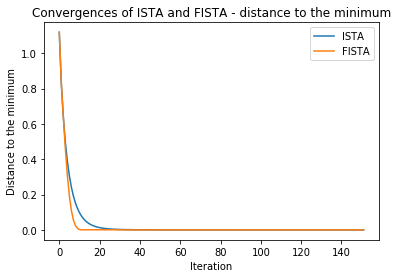

In [24]:
plot_speed(obj1,obj2)

<div class="alert alert-info">
 <ul>

We can see here that FISTA converges faster than ISTA to the same minimum.

</ul>
</div>

        * Estimation error : 

<div class="alert alert-info">    
<ul>

We will also define a function that will be needed to plot the error for the different examples. 

</ul>
</div>

In [25]:
def plot_error(error_ISTA, error_FISTA,log=True):
   
    plt.plot(error_ISTA, label="ISTA")
    plt.plot(error_FISTA, label="FISTA")
    plt.legend()
    
    if (log):
        plt.yscale('log')
    
    plt.xlabel("Iteration")
    plt.ylabel("Estimation error")
    
    if (log):
        plt.title("Estimation error of ISTA and FISTA - log scale")
    else:
        plt.title("Estimation error of ISTA and FISTA")


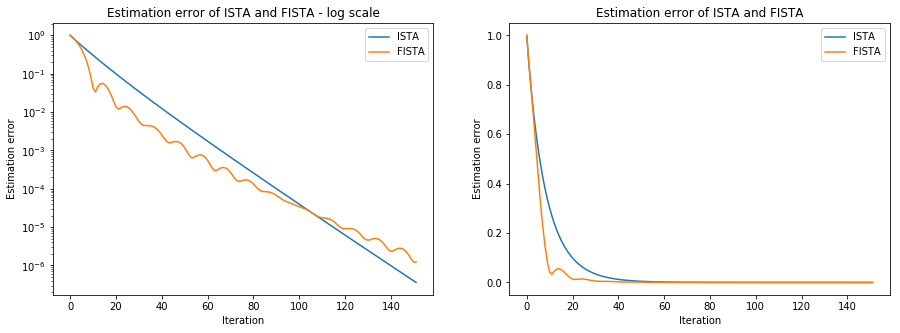

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plot_error(err1, err2)
plt.subplot(122)
plot_error(err1, err2,False)

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>

ISTA algorithm convergs with rate equal to O(1/T) [Worst case]. This can be seen on the first figure above, where we see a linear curve in -log(T).

We can also see that FISTA convergs faster than ISTA. We know that for FISTA's worst case, it convergs with a rate equal to O(1/$T^2$), which is better than O(1/T), but in our case here, as we can see above on the graphs, FISTA oscilates. ( This will be explained at the end of 3rd part of this lab ).


</ul>
</div>

<div class="alert alert-info">

<h4> IMPORTANT : </h4> At first, FISTA was better than ISTA computation wise ( Having the less error in less iterations ). On the other hand, when the number of iterations increases, ISTA becomes better. 

</div>

###    3.2. Linear Regression - Lasso : 

        a. ISTA :

In [27]:
# a) find the true minimizer and the minimum :
x_true, obj, err = ista(x0, loss_linreg, grad_linreg, lasso,
                        prox_lasso, step=lip_linreg(A), s=s, n_iter=1000, verbose=False)

# b) Compare the convergences of ISTA and FISTA, in terms of distance to the minimum anddistance to the minimizer
x_ista_linreg_lasso, obj1, err1 = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
    A), s=s, n_iter=150, verbose=False, x_true=x_true)

In [28]:
print('The true minimizer is for ISTA algorithm is :' + str(x_ista_linreg_lasso[-1]))

The true minimizer is for ISTA algorithm is :-0.010825242757459046


In [29]:
print("The minimum using ISTA : ", obj1[len(obj1) - 1])

The minimum using ISTA :  0.540230131018479


        b. FISTA :

In [30]:
x_fista_linreg_lasso, obj2, err2 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step=lip_linreg(
    A), x_true=x_true, s=s, n_iter=150, verbose=False)

In [31]:
print('The true minimizer is for FISTA algorithm is :' + str(x_fista_linreg_lasso[-1]))

The true minimizer is for FISTA algorithm is :-0.010825406973562903


In [32]:
print("The minimum using FISTA : ", obj2[len(obj2) - 1])

The minimum using FISTA :  0.5402301310188932


        c. ISTA vs FISTA :

<div class="alert alert-info">
<ul>
Same as for the Ridge case, both algorithms give approximately the same results. 
</ul>
</div>

<div class="alert alert-info">
<ul>

|      $ $          | ISTA                 | FISTA                |
|----------------|----------------------|----------------------|
| True minimizer | -0.010825242757459046 | -0.010825406973562903 |
| Minimum        | 0.540230131018479  | 0.5402301310188932  |

</ul>
</div>

            * Speed :

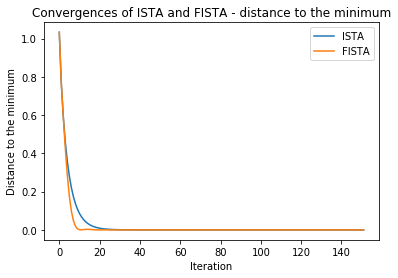

In [33]:
plot_speed(obj1,obj2)

            * Estimation Error : 

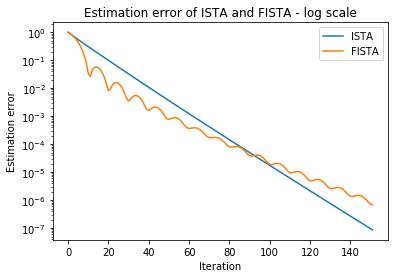

In [34]:
plot_error(err1, err2)

###    3.3. Logistic Regression - Lasso : 

        a. ISTA

In [35]:
x_true, obj, err = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso,
                        step=lip_logreg(A_log), s=s, n_iter=1000, verbose=False)

x_ista_logreg_lasso, obj1, err1 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
    A_log), s=s, n_iter=150, verbose=False, x_true=x_true)

In [36]:
print('The true minimizer is for ISTA algorithm is :' + str(x_ista_linreg_lasso[-1]))

The true minimizer is for ISTA algorithm is :-0.010825242757459046


In [37]:
print("The minimum using ISTA : ", obj1[len(obj1) - 1])

The minimum using ISTA :  0.5740958505381911


        b. FISTA

In [38]:
x_fista_logreg_lasso, obj2, err2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step=lip_logreg(
    A_log), x_true=x_true, s=s, n_iter=150, verbose=False)

In [39]:
print('The true minimizer is for FISTA algorithm is :' + str(x_fista_linreg_lasso[-1]))

The true minimizer is for FISTA algorithm is :-0.010825406973562903


In [40]:
print("The minimum using FISTA : ", obj2[len(obj2) - 1])

The minimum using FISTA :  0.5740958505409215


        c. ISTA vs FISTA

<div class="alert alert-info">
<ul>

|      $ $          | ISTA                 | FISTA                |
|----------------|----------------------|----------------------|
| True minimizer | -0.010825242757459046 | -0.010825406973562903 |
| Minimum        | 0.5740958505381911 | 0.5740958505409215  |

</ul>
</div>

            * Speed :

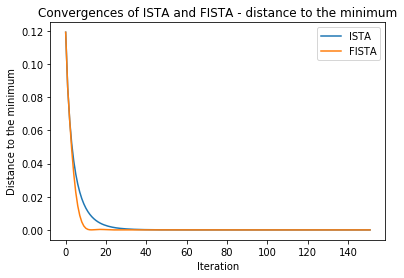

In [41]:
plot_speed(obj1,obj2)

            * Estimation Error :

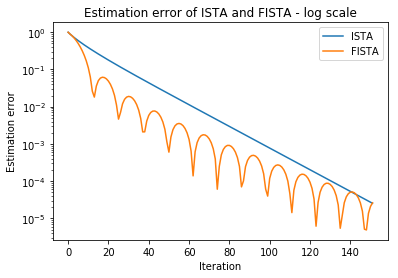

In [42]:
plot_error(err1,err2)

###    3.4. Logistic Regression - Ridge : 

        a. ISTA 

In [43]:
# a) find the true minimizer and the minimum :
x_true, obj, err = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge,
                        step=lip_logreg(A_log), s=s, n_iter=1000, verbose=False)

# b) Compare the convergences of ISTA and FISTA, in terms of distance to the minimum anddistance to the minimizer
x_ista_logreg_ridge, obj1, err1 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
    A_log), s=s, n_iter=150, verbose=False, x_true=x_true)

In [44]:
print('The true minimizer is for ISTA algorithm is :' + str(x_ista_linreg_lasso[len(x_ista_linreg_lasso)-1]))

The true minimizer is for ISTA algorithm is :-0.010825242757459046


In [45]:
print("The minimum using ISTA : ", obj1[len(obj1) - 1])

The minimum using ISTA :  0.4980561874129971


        b. FISTA

In [46]:
x_fista_logreg_ridge, obj2, err2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step=lip_logreg(
    A_log), x_true=x_true, s=s, n_iter=150, verbose=False)

In [47]:
print('The true minimizer is for FISTA algorithm is :' + str(x_fista_linreg_lasso[len(x_fista_linreg_lasso)-1]))

The true minimizer is for FISTA algorithm is :-0.010825406973562903


In [48]:
print("The minimum using FISTA : ", obj2[len(obj2) - 1])

The minimum using FISTA :  0.4980554654575385


        c. ISTA vs FISTA



<div class="alert alert-info">
<ul>

|          $ $      | ISTA                 | FISTA                 |
|----------------|----------------------|-----------------------|
| True minimizer | -0.010825242757459046 | -0.010825406973562903 |
| Minimum        | 0.4980561874129971 | 0.4980554654575385  | 

</ul>
</div>

            * Speed 

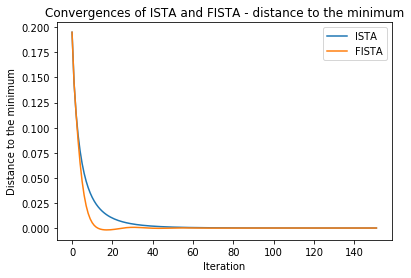

In [49]:
plot_speed(obj1, obj2)

            * Estimation Error 

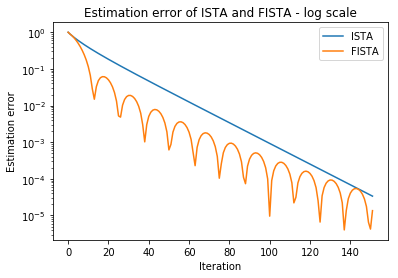

In [50]:
plot_error(err1,err2)

<div class="alert alert-info">

#### Comments of ISTA and FISTA :

The loss and distance to optimum of the FISTA algorithm oscillates because FISTA is not a gradient descent, since the objective is not monotonous. So that what made the objective oscilates ( It can increase from one iteration to another one but still converges to the minimum ). 

We notice that FISTA converges faster at the beginning (it's due to the fact that it is not a gradient descent).

</div>

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

<a id='exer'></a>
## Exercice : 

### A) Compare the solution you obtain with ista and fista with the true parameter coefs of the model. This can be done with plt.stem plots :


In [51]:
def plotc_fista_ista(x0, loss, grad, regul, prox_regul, lip_model, s, n_iter=150, verbose=False):
    
    x_ista, obj_ista, err_ista = ista(x0, loss, grad, regul, prox_regul, lip_model(A), s, n_iter, verbose=False)

    x_fista, obj_fista, err_fista = fista(x0, loss, grad, regul, prox_regul, lip_model(A), s, n_iter, verbose=False)
    
    plt.figure(figsize=(15,15))
    plt.subplot(311)
    plt.stem(x_ista, label="ISTA", linefmt='r', markerfmt='rX')
    plt.stem(coefs, label="COEFS", linefmt='b', markerfmt='bo')
    plt.legend()
    plt.subplot(312)
    plt.stem(x_fista, label="FISTA", linefmt='k', markerfmt='kX')
    plt.stem(coefs, label="COEFS", linefmt='b', markerfmt='bo')
    plt.legend()
    plt.subplot(313)
    plt.stem(x_ista, label="ISTA", linefmt='r', markerfmt='rX')
    plt.stem(x_fista, label="FISTA", linefmt='k', markerfmt='ko')
    plt.legend()

### Linear Regression - Ridge : 

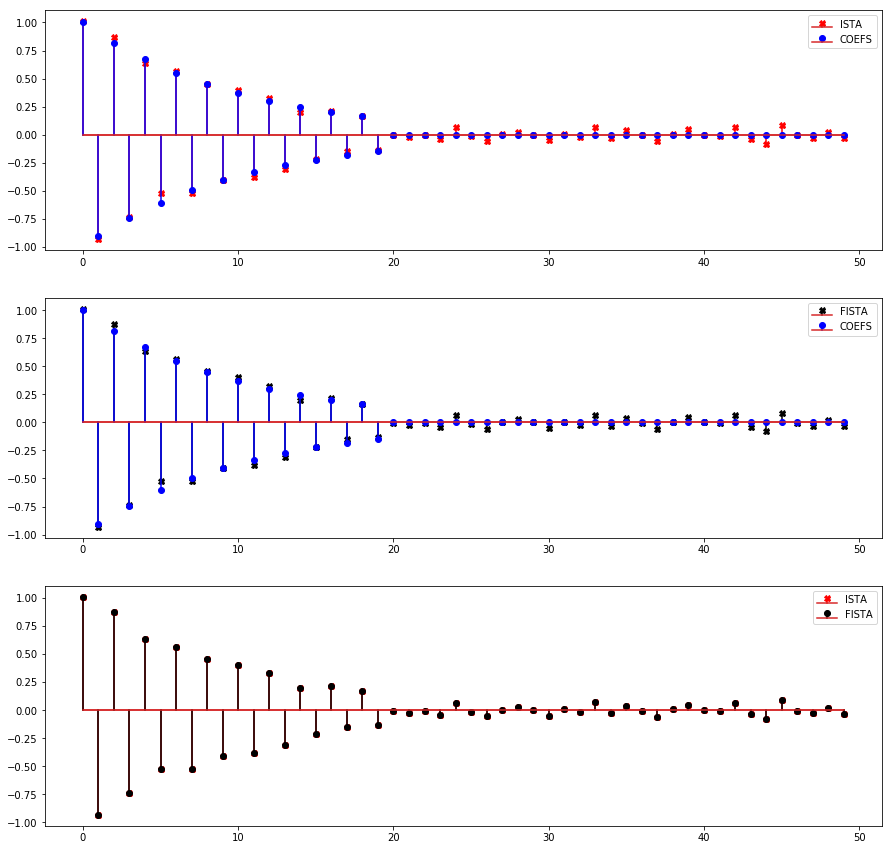

In [52]:
plotc_fista_ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, lip_linreg, s, n_iter=150, verbose=True)

Coefs is not the true minimal. 
Comparing to coefs doesnt make sense. 

### Linear Regression - Lasso :

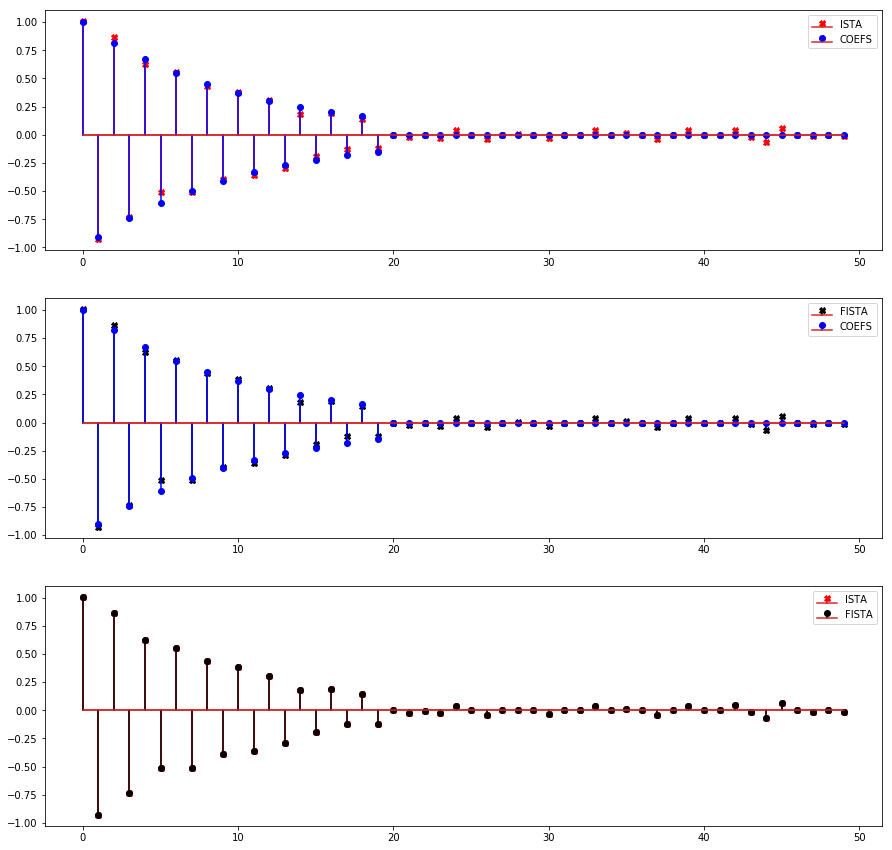

In [53]:
plotc_fista_ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, lip_linreg, s, n_iter=150, verbose=True)

### Logistic regression - Ridge :

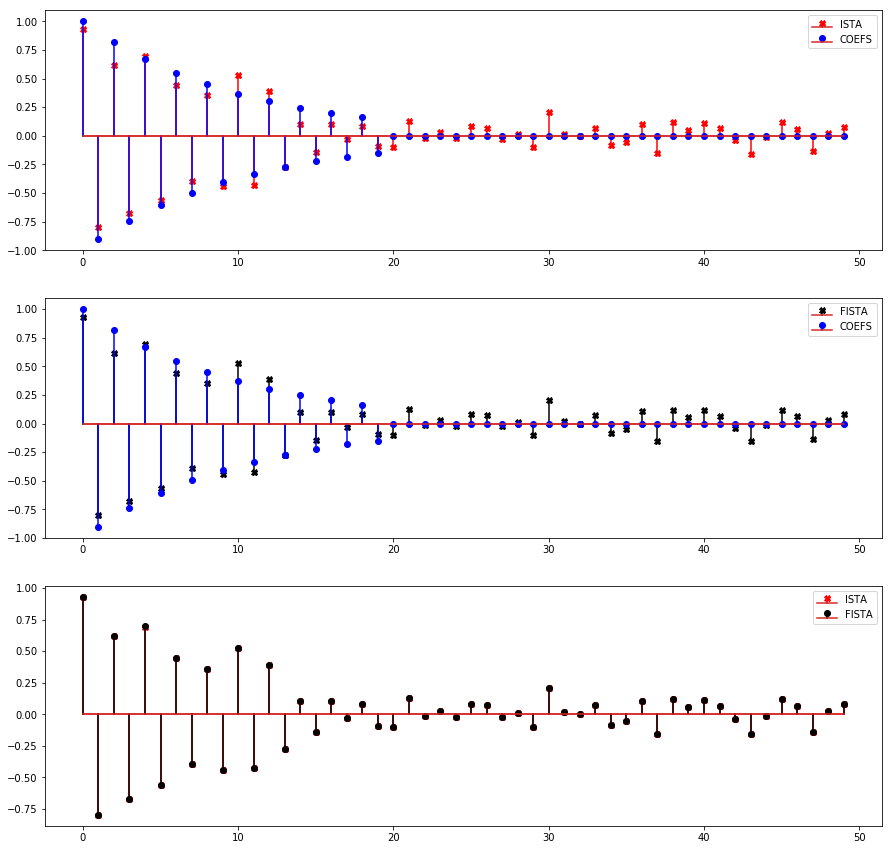

In [54]:
plotc_fista_ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, lip_logreg, s, n_iter=150, verbose=True)

### Logstic regression - Lasso : 

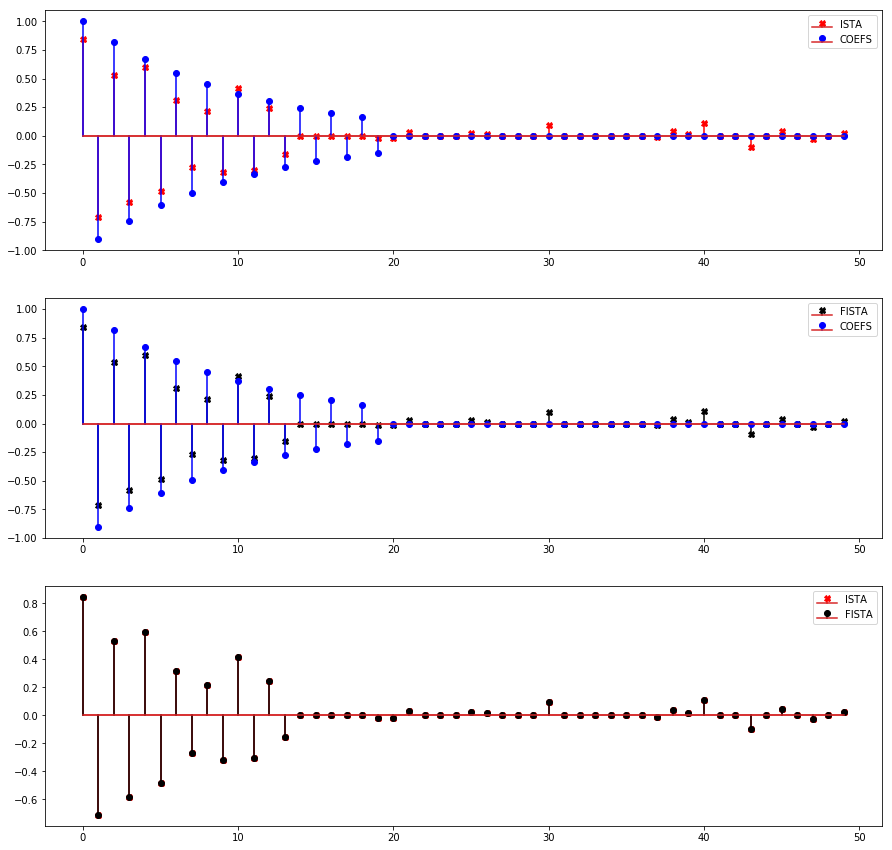

In [55]:
plotc_fista_ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, lip_logreg, s, n_iter=150, verbose=True)

<div class="alert alert-info">
    <b>Comments</b>:

For this question, we are doing a comparison between coefs and both x_ista and x_fista. The thing is that coefs is not the x_true we are looking for. So, I think that this comparison does not make sens.

We should have compared x_true and both x_ista and x_fista.

NB : X_ista and X_fista are very similar like we showed here in every 3rd plot.

</div>

### B) The influence of the correlation on the performance of the optimization algorithms :


In [56]:
def call(x0, loss, grad, regul, prox_regul, lip_model, s, n_iter, verbose=False):
    
    x_true, obj, err = ista(x0, loss, grad, regul, prox_regul, lip_model, s=s, n_iter=n_iter, verbose=False)
    
    x, obj_ista, error_ista = ista(x0, loss, grad, regul, prox_regul, lip_model, s=s, n_iter=n_iter, verbose=False,x_true=x_true)
    
    x, obj_fista, error_fista = fista(x0, loss, grad, regul, prox_regul, lip_model,x_true=x_true, s=s, n_iter=n_iter, verbose=False)
    
    return obj_ista,obj_fista,error_ista,error_fista
    

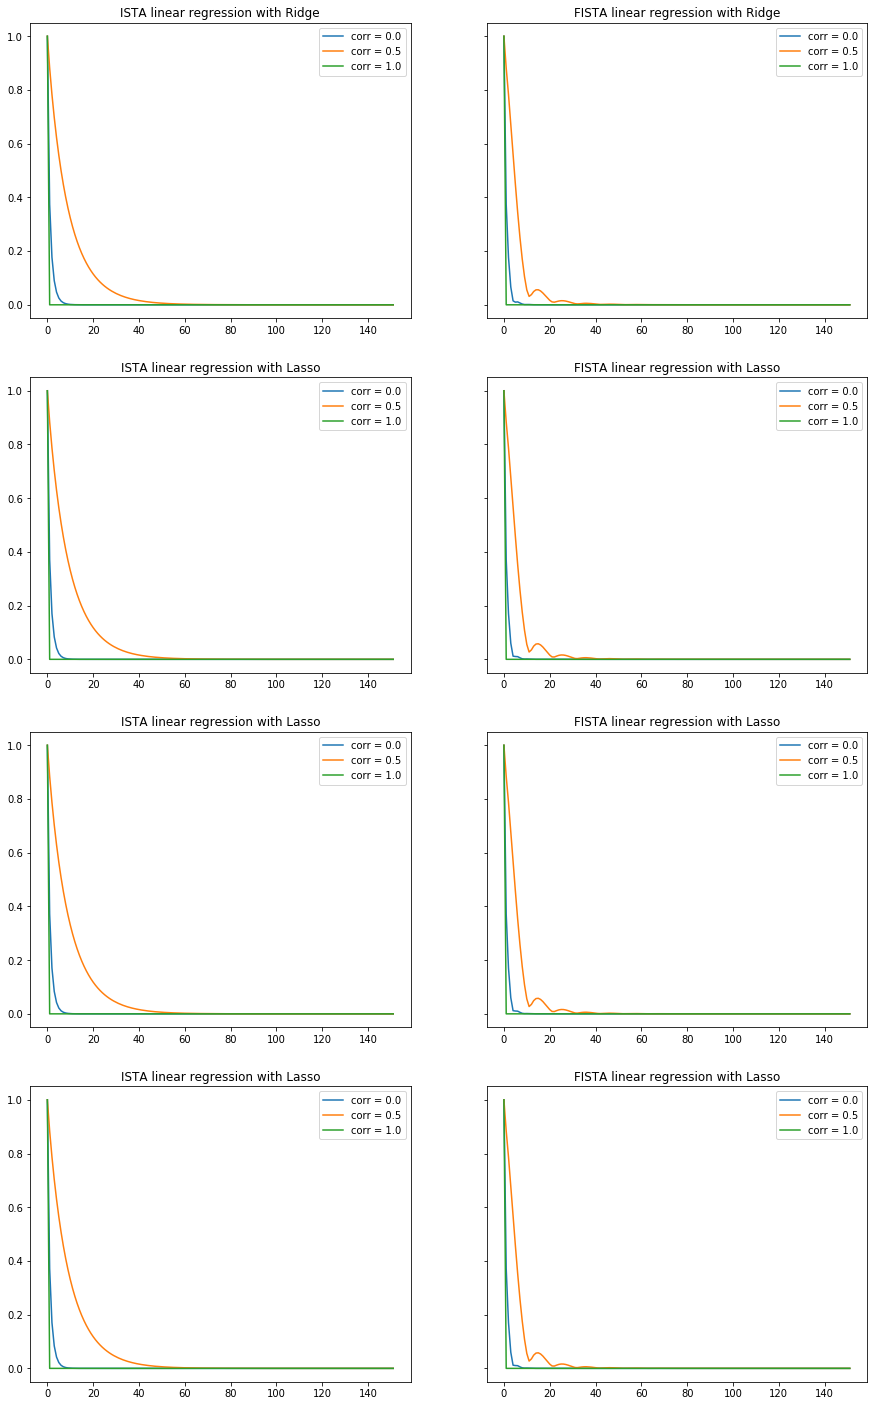

In [57]:
f, axarr = plt.subplots(4, 2, sharey=True, figsize=(15, 25))

for i in np.linspace(0, 1, num=3):
   
    A, b = simu_linreg(coefs, corr=i)
    A_log, b_log = simu_logreg(coefs, corr=i)
   
    #-----------------------------------------------------------------------------------------------------
    
    obj_ista_lingreg_ridge,obj_fista_linreg_ridge,error_ista_lingreg_ridge,error_fista_lingreg_ridge=call(x0, 
              loss_linreg, grad_linreg, ridge,prox_ridge, lip_model=lip_linreg(A), s=s, n_iter=150, verbose=False)
   
    #-----------------------------------------------------------------------------------------------------
    
    obj_ista_lingreg_lasso,obj_fista_linreg_lasso,error_ista_lingreg_lasso,error_fista_lingreg_lasso=call(x0, 
              loss_linreg, grad_linreg, lasso,prox_lasso, lip_model=lip_linreg(A), s=s, n_iter=150, verbose=False)
    
    #-----------------------------------------------------------------------------------------------------
    
    obj_ista_logreg_ridge,obj_fista_logreg_ridge,error_ista_logreg_ridge,error_fista_logreg_ridge=call(x0, 
              loss_logreg, grad_logreg, ridge,prox_ridge, lip_model=lip_logreg(A_log), s=s, n_iter=150, verbose=False)
        
    #-----------------------------------------------------------------------------------------------------

    obj_ista_logreg_lasso,obj_fista_logreg_lasso,error_ista_logreg_lasso,error_fista_logreg_lasso=call(x0, 
              loss_logreg, grad_logreg, lasso,prox_lasso, lip_model=lip_logreg(A_log), s=s, n_iter=150, verbose=False)
    
    #-----------------------------------------------------------------------------------------------------
    
    err_fista=[error_fista_lingreg_ridge,error_fista_lingreg_lasso,error_fista_logreg_ridge,error_fista_logreg_lasso]
        
    err_ista=[error_ista_lingreg_ridge,error_ista_lingreg_lasso,error_ista_logreg_ridge,error_ista_logreg_lasso]

    name_err=['linear regression with Ridge','linear regression with Lasso','logistic regression with Ridge','logistic regression with Lasso']
    
    k=0
    for j in range(0,4):   
        axarr[j][0].plot(err_ista[k], label="corr = " + str(i))
        axarr[j][0].set_title('ISTA '+name_err[k])
        axarr[j][0].legend()
        axarr[j][1].plot(err_fista[k], label="corr = " + str(i))
        axarr[j][1].set_title('FISTA '+name_err[k])
        axarr[j][1].legend()
        k=+1
        
    

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>
We can see that whenever we increase the correlation, the algorithm convergs less rapidly, but when we decrease the correlation, the algorithm convergs faster. 

And the proof of that is that we know : 

$$||x^{t+1}-x^*||_2 < (1-cond(A))^t||x^{0}-x^*||_2$$

On the other hand, we know that when the correlation decreases, the condition number of the matrix increases, so therefore, as we noticed, the algorithm convergs faster.     </ul>
</div>



## C) The influence of the level of ridge penalization on the performance of the optimization algorithms.


/usr/lib/python3/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/lib/python3/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


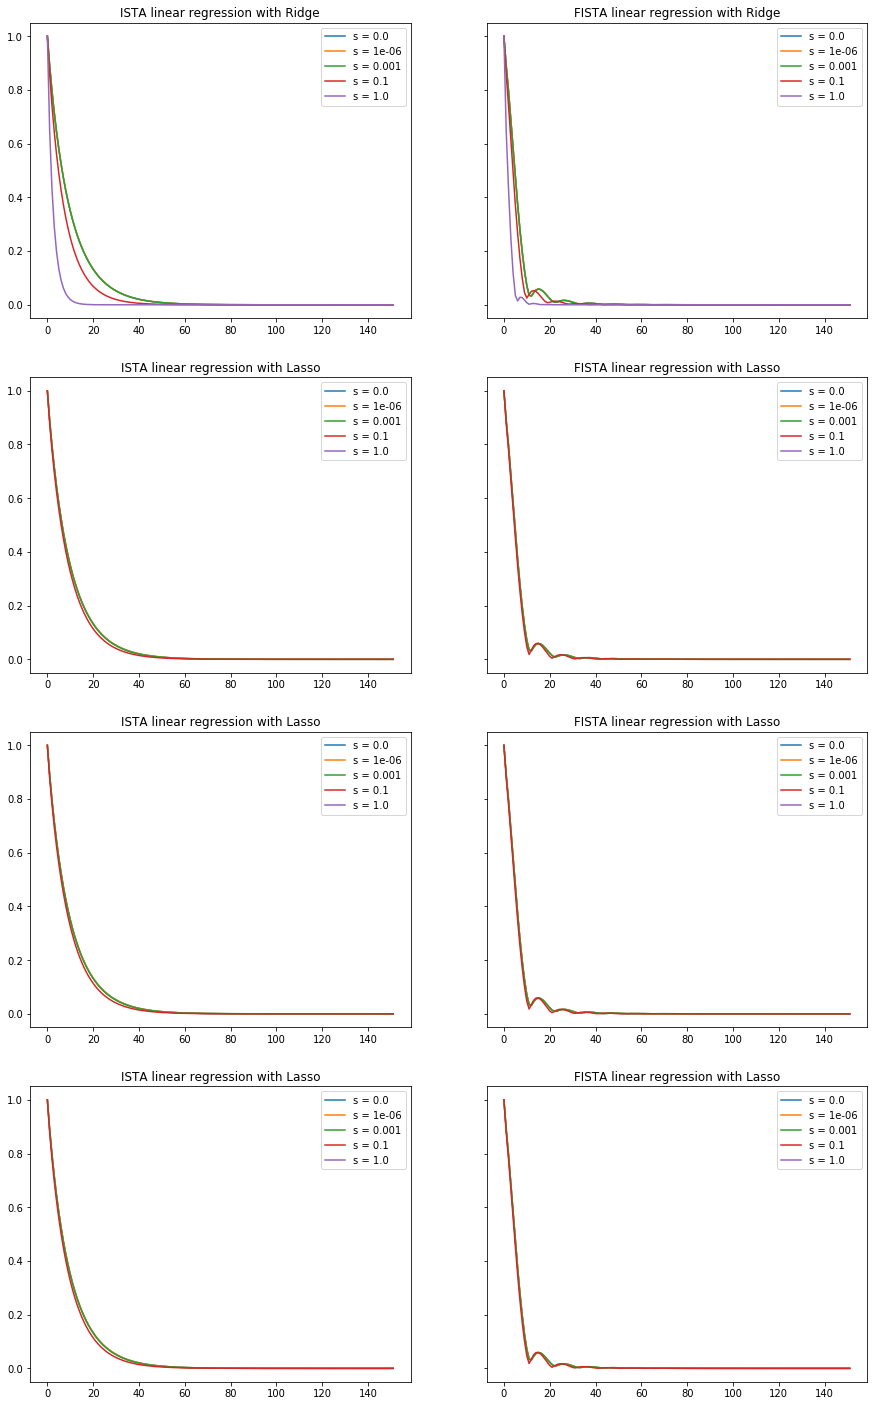

In [58]:
f, axarr = plt.subplots(4, 2, sharey=True, figsize=(15, 25))

s_array = np.array([0,  1e-6, 1e-3,  1e-1, 1])

A, b = simu_linreg(coefs)
A_log, b_log = simu_logreg(coefs)

for i in s_array:
   
   
    #-----------------------------------------------------------------------------------------------------
    
    obj_ista_lingreg_ridge,obj_fista_linreg_ridge,error_ista_lingreg_ridge,error_fista_lingreg_ridge=call(x0, 
              loss_linreg, grad_linreg, ridge,prox_ridge, lip_model=lip_linreg(A), s=i, n_iter=150, verbose=False)
   
    #-----------------------------------------------------------------------------------------------------
    
    obj_ista_lingreg_lasso,obj_fista_linreg_lasso,error_ista_lingreg_lasso,error_fista_lingreg_lasso=call(x0, 
              loss_linreg, grad_linreg, lasso,prox_lasso, lip_model=lip_linreg(A), s=i, n_iter=150, verbose=False)
    
    #-----------------------------------------------------------------------------------------------------
    
    obj_ista_logreg_ridge,obj_fista_logreg_ridge,error_ista_logreg_ridge,error_fista_logreg_ridge=call(x0, 
              loss_logreg, grad_logreg, ridge,prox_ridge, lip_model=lip_logreg(A_log), s=i, n_iter=150, verbose=False)
        
    #-----------------------------------------------------------------------------------------------------

    obj_ista_logreg_lasso,obj_fista_logreg_lasso,error_ista_logreg_lasso,error_fista_logreg_lasso=call(x0, 
              loss_logreg, grad_logreg, lasso,prox_lasso, lip_model=lip_logreg(A_log), s=i, n_iter=150, verbose=False)
    
    #-----------------------------------------------------------------------------------------------------
    
    err_fista=[error_fista_lingreg_ridge,error_fista_lingreg_lasso,error_fista_logreg_ridge,error_fista_logreg_lasso]
        
    err_ista=[error_ista_lingreg_ridge,error_ista_lingreg_lasso,error_ista_logreg_ridge,error_ista_logreg_lasso]

    name_err=['linear regression with Ridge','linear regression with Lasso','logistic regression with Ridge','logistic regression with Lasso']
    
    k=0
    for j in range(0,4):   
        axarr[j][0].plot(err_ista[k], label="s = " + str(i))
        axarr[j][0].set_title('ISTA '+name_err[k])
        axarr[j][0].legend()
        axarr[j][1].plot(err_fista[k], label="s = " + str(i))
        axarr[j][1].set_title('FISTA '+name_err[k])
        axarr[j][1].legend()
        k=+1

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>
We notice that when we increase the level of penalization, the algorithms convergs more rapidly. 

On the other hand, we notice that increasing the regularization parameter s constrains more the coefficients and if "s" is sufficiently large, the solution is zero.</ul>
</div>




## D) Comparaison between the performance of the optimization algorithms for ridge and lasso penalizations.

In [59]:
def plot_comparaison_penal( loss_model, grad_model,  lip_model, verbose=False):

    type_reg = [ridge, lasso]
    type_prox = [prox_ridge, prox_lasso]
    l = ['Ridge', 'Lasso']
    # Two subplots, the axes array is 1-d

    f, axarr = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
    
    A, b = simu_linreg(coefs)
    A_log, b_log = simu_logreg(coefs)

    for i in range(2):

        x_true, obj, err = ista(x0, loss_model, grad_model, type_reg[i], type_prox[i], step=lip_model(
            A), s=s, n_iter=150, verbose=False)
        
        x, obj_ista, error_ista = ista(x0, loss_model, grad_model, type_reg[i], type_prox[i], step=lip_model(
            A), s=s, n_iter=150, verbose=False)
        
        x, obj_fista, error_fista = fista(x0, loss_model, grad_model, type_reg[i], type_prox[i], step=lip_model(
            A), s=s, n_iter=150, verbose=False)

        axarr[0].plot(error_ista, label=l[i])
        axarr[0].set_title('ISTA')
        axarr[0].legend()
        axarr[0].set_ylabel('Estimation error')
        axarr[1].plot(error_fista, label=l[i])
        axarr[1].set_title('FISTA')
        axarr[1].legend()
        axarr[1].set_ylabel('Estimation error')

### Linear regression :

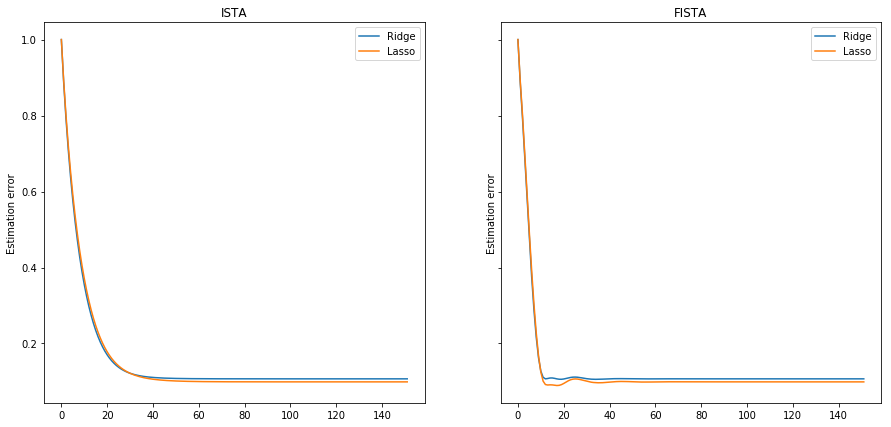

In [60]:
plot_comparaison_penal(loss_linreg, grad_linreg,  lip_linreg, verbose=False)

### Logistic regression :

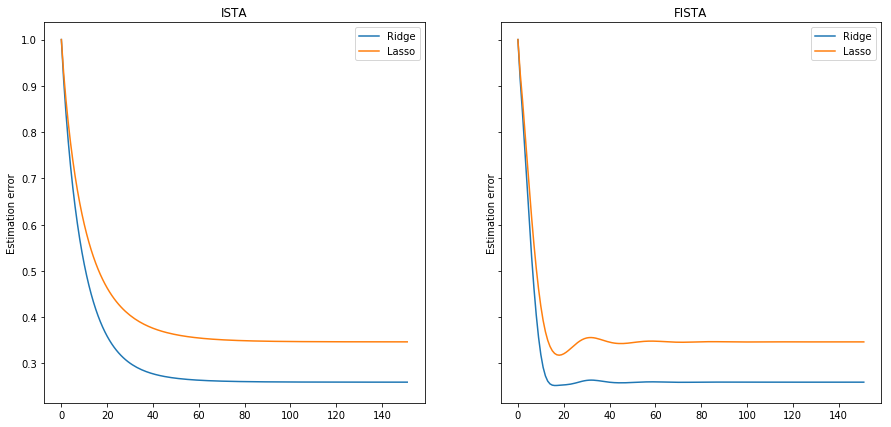

In [61]:
plot_comparaison_penal(loss_logreg, grad_logreg,  lip_logreg, verbose=False)

<div class="alert alert-info">
    <b>Comments</b>:
     <ul>
<h3> For Linear regression : </h3> They almost have the same curves. On those graphs, we can see that both algorithms convergs with almost the same speed, with a very slight difference in favor of Lasso. 

<h3> For Logistic regression : </h3> We see clearly here that ridge penalization, is way better than Lasso's.

In fact, each of these two penalizations has its advantages, because for the Ridge case, it reduces the model comlexity and favors coefficient shrinkage. From the other hand, Lasso performs feature selection add to coeff shrinkage and provides sparse solutions. 

</ul>
</div>






<h2> End of lab 1 </h2>